### Napari tests

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
from pathlib import Path
cur_path = Path(os.getcwd()).parent

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style='white')
%config InlineBackend.figure_format = 'retina'

In [3]:
import napari

In [4]:
viewer = napari.Viewer()

#### Initiate the SAM2 model like you do in Napari

In [5]:
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch
from octron.sam2_octron.helpers.build_sam_octron import build_sam2_video_predictor_octron

In [34]:
sam2_folder = Path('sam2_octron')
checkpoint = 'sam2.1_hiera_large.pt' # under folder /checkpoints
model_cfg = 'sam2.1/sam2.1_hiera_l.yaml' # under folder /configs
# ------------------------------------------------------------------------------------
sam2_checkpoint = cur_path / sam2_folder / Path(f'checkpoints/{checkpoint}')
model_cfg = Path(f'configs/{model_cfg}')


predictor, device  = build_sam2_video_predictor_octron(config_file=model_cfg.as_posix(), 
                                                       ckpt_path=sam2_checkpoint.as_posix(), 
                                     )


Support for MPS devices is preliminary. SAM 2 is trained with CUDA and might give numerically different outputs and sometimes degraded performance on MPS. See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion.
Uing device: mps


Loaded SAM2VideoPredictor OCTRON
Model image size: 1024


### From napari, after loading video file, extract info 

In [7]:
# ... first load video into napari 

In [10]:
viewer.dims.set_point(0,10)
current_indices = viewer.dims.current_step
print(current_indices)

(10, 971, 971)


In [35]:
video_data = viewer.layers[0].data   # the whole video

num_frames = video_data.shape[0]
frame_height = video_data[0].shape[0]
frame_width = video_data[0].shape[1]
print(f'video shape: {video_data.shape}')   

video shape: (1603, 1944, 1944, 3)


In [36]:
def get_mean_std(video_data, num_frames, max_num_frames=50):
    '''
    Given a large video data set, 
    calculate the mean and std of a subset 
    of all frames 
    ''' 
    num_frames = video_data.shape[0]
    which_frames = np.linspace(0, num_frames-1, np.min([num_frames, max_num_frames])).astype(int)
    accumulated_frames = np.stack([video_data[i] for i in which_frames])
    mean = np.mean(accumulated_frames,axis=None)
    std =  np.std(accumulated_frames,axis=None)
    return mean, std

In [37]:
img_mean, img_std = get_mean_std(video_data, num_frames, max_num_frames=100)
print(f'Mean: {img_mean:.1f}, Std: {img_std:.1f}')   

Mean: 44.8, Std: 42.8


In [38]:
# We want to get tdeo inference state initialization 

Text(0.5, 1.0, 'First frame')

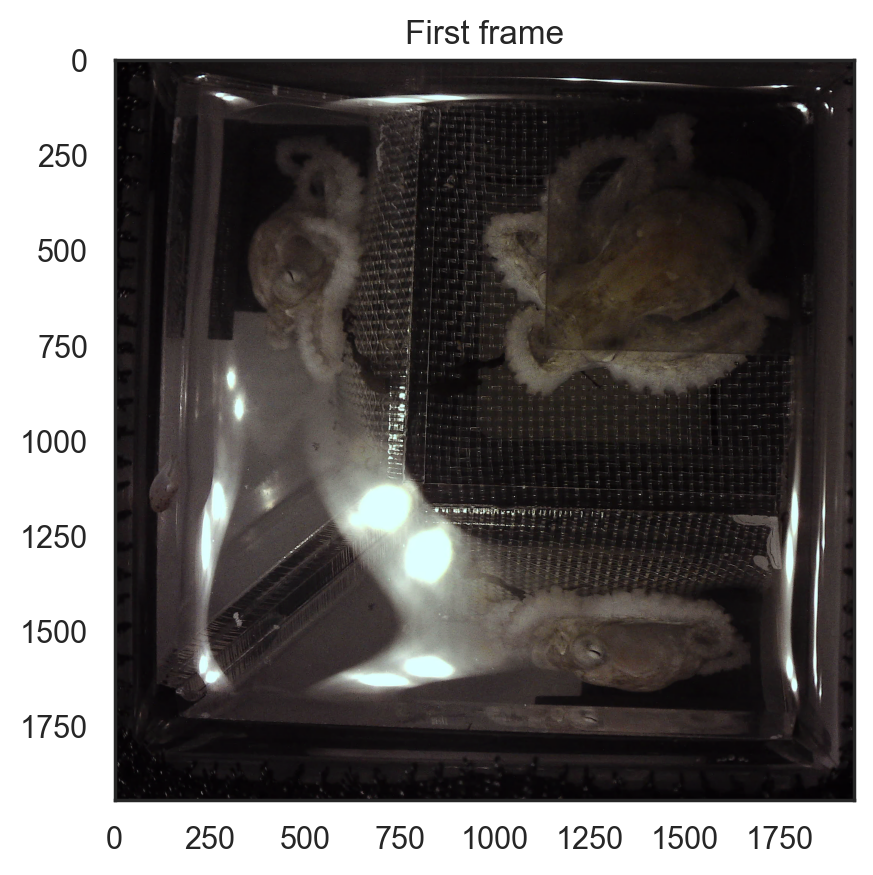

In [39]:
img_np = video_data[:60] # Get the first 30 frames
plt.imshow(img_np[0])
plt.title('First frame')

In [40]:
img_np.shape

(60, 1944, 1944, 3)

In [41]:
from skimage.transform import resize

In [46]:
img_np = [resize(img, (1024,1024)) for img in img_np]

In [47]:
images = [torch.from_numpy(img).permute(2, 0, 1) for img in img_np]
images = torch.stack(images, dim=0).float() / 255.0

img_mean=(0.485, 0.456, 0.406)
img_std=(0.229, 0.224, 0.225)
img_mean = torch.tensor(img_mean, dtype=torch.float32)[:, None, None]
img_std = torch.tensor(img_std, dtype=torch.float32)[:, None, None]
print(img_mean.shape, img_std.shape )  
images = images.to(device)
img_mean = img_mean.to(device)
img_std = img_std.to(device)


# # #  # normalize by mean and std
images -= img_mean
images /= img_std

torch.Size([3, 1, 1]) torch.Size([3, 1, 1])


In [48]:
images.shape

torch.Size([60, 3, 1024, 1024])

In [49]:
inference_state = predictor.init_state(images=images, 
                                      )

In [8]:
# viewer.dims.set_point(0,10)
# current_indices = viewer.dims.current_step
# print(current_indices)
# image_data1 = viewer.layers[0].data[current_indices[0],:,:,:]
# image_data1.shape
# plt.imshow(image_data1)
# plt.show() 
# # Set to different index 
# viewer.dims.set_point(0,11)
# current_indices = viewer.dims.current_step
# print(current_indices)
# current_indices = viewer.dims.current_step
# image_data2 = viewer.layers[0].data[current_indices[0],:,:,:]
# image_data2.shape
# plt.imshow(image_data2)
